This notebook is where I estimate the number of detections IceCube with Upgrade will get of cosmic ray lunar neutrinos

In [3]:
import random

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
import math
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
#This function returns cosmic ray flux per Gaisser
#units are /SR/s/M^2/log(Gev)
def get_cosmic_ray_flux(log_energy): # / log gev
    return 1.7 * (10 ** 4) * ((10 ** log_energy) ** -2.7) * (10 ** log_energy) * np.log(10)

In [10]:
"""log_energies = np.linspace(-1, 2, 100)
flux_values = [get_cosmic_ray_flux(log_energy) for log_energy in log_energies]

plt.plot(log_energies, flux_values)"""

'log_energies = np.linspace(-1, 2, 100)\nflux_values = [get_cosmic_ray_flux(log_energy) for log_energy in log_energies]\n\nplt.plot(log_energies, flux_values)'

In [4]:
#Determines how much energy a cosmic ray "loses" when it decays into a neutrino in our atmosphere
#current model is gaussian distribution centered around 1 log(GeV) with a standard deviation of 1/4 (log(Cosmic Ray Energy))
def decide_energy_loss(log_energy):
    energy_loss = np.random.normal(1, abs(log_energy) / 4, 1)[0]
    return energy_loss

In [33]:
#Uses a monte carlo simulation to create and a function which takes log neutrino energy as an input and returns differential neutrino flux
    #Differential neutrino flux is in units of neutrinos/log(GeV)
def make_neutrino_flux_function_using_mc():
    #range of cosmic ray energies we care about
    log_min_cr_energy = 0
    log_max_cr_energy = 2
    
    #range of possible cosmic ray fluxes 
    min_flux = get_cosmic_ray_flux(log_min_cr_energy)
    max_flux = get_cosmic_ray_flux(log_max_cr_energy)
    
    #make histogram to store neutrino counts
    #energy bins in log(GeV)
    log_neutrino_min_energy = log_min_cr_energy - 1.5
    log_neutrino_max_energy = log_max_cr_energy - 0.5
    num_bins = 100
    log_neutrino_energy_bins = np.linspace(log_neutrino_min_energy, log_neutrino_max_energy, num_bins + 1) 
    neutrino_energy_histogram = np.zeros(num_bins) 


    for i in range(10 ** 8): #change back to 10 ** 8 
        #pick random cosmic ray energy and associated CR flux
        log_random_CR_energy = random.uniform(log_min_cr_energy, log_max_cr_energy)
        random_flux = random.uniform(min_flux, max_flux)
        
        if random_flux < get_cosmic_ray_flux(log_random_CR_energy): #decide whether to include cosmic ray (and the neutrino it produces)
            log_neutrino_energy = log_random_CR_energy - decide_energy_loss(log_random_CR_energy) #decide what the produced neutrino's energy is
            bin_index = np.digitize(log_neutrino_energy, log_neutrino_energy_bins) - 1 
            if 0 <= bin_index < num_bins:
                neutrino_energy_histogram[bin_index] += 1 #add neutrino to histogram
    
    bin_centers = (log_neutrino_energy_bins[:-1] + log_neutrino_energy_bins[1:]) / 2

    neutrino_count_interp = interp1d(bin_centers, neutrino_energy_histogram, kind='linear') #interpolating neutrino energy histogram
    
    #We need out how many cosmic rays actually produced neutrinos in this energy range
    #So we calculate this, and then adjust our histogram interpolation to have the correct flux magnitude (and not just shape)
    #Assumes a 1-1 ratio of cosmic rays to neutrinos
    total_count = quad(neutrino_count_interp, log_min_cr_energy - 1.45, log_max_cr_energy - 0.55, limit=1000)[0] #not ideal that this gives integration errors but I think its alright
    total_cosmic_rays = quad(get_cosmic_ray_flux, log_min_cr_energy, log_max_cr_energy)[0]
    scale_factor = total_cosmic_rays / total_count
    def neutrino_flux_interp(log_energy):
        return neutrino_count_interp(log_energy) * scale_factor
    
    return neutrino_flux_interp 


In [34]:
get_neutrino_flux = make_neutrino_flux_function_using_mc()

/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_93892/2302902760.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  total_count = quad(neutrino_count_interp, log_min_cr_energy - 1.45, log_max_cr_energy - 0.55, limit=1000)[0] #not ideal that this gives integration errors but I think its alright


In [7]:
quad(get_cosmic_ray_flux, 0, 2)

(9996.018928294465, 1.1097810368781396e-10)

In [8]:
quad(get_neutrino_flux, -1.45, 1.45, limit=1000)

/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_93892/100246254.py:1: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(get_neutrino_flux, -1.45, 1.45, limit=1000)


(9996.018928294483, 0.13980382790578005)

In [9]:
#This is all code I got from IceCube's website
#Allows me to get effective of IceCube (with upgrade)

# Define path to file (you may need to change this to match your system)
input_file = "neutrino_mc.csv"

# Load the file using pandas
input_data = pd.read_csv(input_file)

# Defining a few useful thing sbefore we get started...

# Define some energy bins (used throughout this notebook)
energy_bins_fine = np.logspace(0., 2., num=21)
energy_bins_course = np.logspace(0., 2., num=11)

# Define masks to identify different neutrino flavors
nue_mask = (np.abs(input_data["pdg"]) == 12)
numu_mask = (np.abs(input_data["pdg"]) == 14)
nutau_mask = (np.abs(input_data["pdg"]) == 16)

# It is often desirable to seperate the neutrinos by flavor and interaction.
# It is common to consider all Neutral Current (NC) interactions together, as 
# there is no final state charged lepton with which to discriminate the different 
# neutrino flavors.
# Define masks to identify different flavor/interaction combinations.
nc_mask = input_data["current_type"] == 0
cc_mask = input_data["current_type"] == 1
nue_cc_mask = nue_mask & cc_mask
numu_cc_mask = numu_mask & cc_mask
nutau_cc_mask = nutau_mask & cc_mask
# Choosing nue CC events as an example
chosen_mask = numu_cc_mask

# Calc effective area
effective_area_hist, bin_edges = np.histogram(input_data["true_energy"][chosen_mask], weights=input_data["weight"][chosen_mask], bins=energy_bins_fine )
effective_area_hist /= 4. * np.pi # Normalise by solid angle (using the fully sky)
effective_area_hist /= np.diff(bin_edges) # Bin widths

def get_aeff_upgrade(log_energy): #returns effective are of the updated ice cube in m^2
    bin_index = np.searchsorted(bin_edges, 10 ** log_energy, side='right')
    return effective_area_hist[bin_index]

In [10]:
#the upgrade aeff graph we get from IceCube is a step function
#this returns a smoother interpolation so that graphs don't come out looking strange
def make_aeff_upgrade_interp():
    log_aeff_energies = np.linspace(-2, 1.9, 30)
    aeffs = []
    
    for log_energy in log_aeff_energies:
        aeffs.append(get_aeff_upgrade(log_energy))
    
    aeff_interpolation = interp1d(log_aeff_energies, aeffs, kind="linear")
    return aeff_interpolation

In [11]:
get_aeff_upgrade_interpolated = make_aeff_upgrade_interp()

In [12]:
#returns an estimate of differential interactions of cosmic ray neutrinos that pass through the moon and hit iceCube (upgraded)
#units are interactions/log(GeV)
def get_diff_interactions(log_neu_energy):
    r_moon = 1737 * 10 ** 3 #m    
    dist_moon_to_earth = 384400 * 10 ** 3 # m 
    
    moon_surface_area = 4 * np.pi * (r_moon ** 2) #m^2
    
    total_neutrino_flux = get_neutrino_flux(log_neu_energy) * moon_surface_area * 2 * np.pi #total neutrinos coming from moon in all directions

    IceCube_flux_fraction = get_aeff_upgrade_interpolated(log_neu_energy) / (4 * np.pi * (dist_moon_to_earth ** 2)) # calculate what fraction total flux emitted would hit iceCube's effective area
    
    diff_interactions = total_neutrino_flux * IceCube_flux_fraction #calculate the precise number if differential interactions 
    
    return diff_interactions #per log GeV

In [13]:
#returns total expected interactions (from cosmic ray lunar neutrinos with iceCube upgrade) in an energy range
def get_total_interactions(log_min_energy, log_max_energy):    
    return quad(get_diff_interactions, log_min_energy, log_max_energy, limit=100)[0]

In [14]:
get_total_interactions(0, 0.99)

5.574699415438587e-08

In [17]:
get_diff_interactions(0.5)

np.float64(2.8133068210834663e-08)

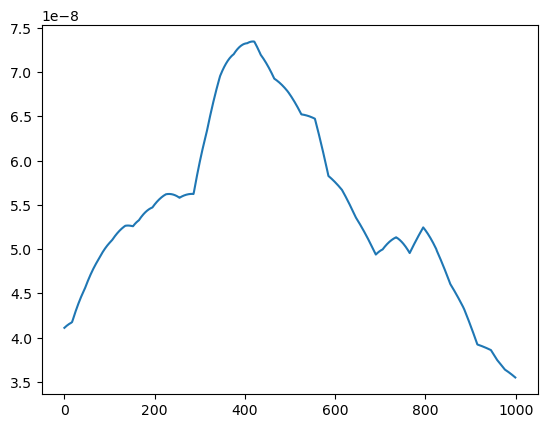

In [35]:
log_energies = np.linspace(0, 0.999, 1000)
plt.plot(get_diff_interactions(log_energies))